# **Deep Learning (Data Preprocessing)** <br/>
**Master's  Degree Program in Data Science and Advanced Analytics, with a specialization in Data Science (A.Y. 2022/2023)**<br/>
**NOVA IMS**<br/>

## Group Members
```
20220604 - Adriana Monteiro - 20220604@novaims.unl.pt
20170746 - Inês Nascimento - r20170746@novaims.unl.pt
20220640 - Janaina Santos - 20220640@novaims.unl.pt
20221396 - Stanislav Slesarev - 20221396@novaims.unl.pt
20220609 - Samuel Santos - 20220609@novaims.unl.pt
```
## Data Source link:
https://drive.google.com/drive/folders/1MQihgKcmoiZS0BUjL9kwigmhKmgt8PHJ?usp=share_link

## Summary

The preprocessing notebook aims to enhance the images for further analysis and diagnostic purposes.

The first approach was to first generate images by data augmentation in order to balance the different classes. Then, accordlying to previous studies [2,3,4], turning the background into black and highlight the cells with purple contrast.

The second approach was to use the original data set and provide class weights when training the model to take into account any class imbalance, thus improving its performance on underrepresented classes. Also, using Keras ImageDataGenerator to generate batches of tensor image data with real-time data augmentation in the training dataset in order to reduce the chance of overfitting.

Once those steps were done, the different combinations of those preprocessed data were tested comparing to the original data in the base model to test if the transformations improved the performance. The better result was given by the second approach.

## Findings

By comparing the original dataset to the two previously defined preprocessing options, we established that, when running 10 epochs, the model with the second option of preprocessing performs better on the base model in terms of validation accuracy, recall and precision. So, we chose the second approach for preprocessing (original images + class weights + image data augmentation, but without black images).

In cancer diagnosis, the recall metric is important because it represents the proportion of true positive cases (people with cancer) that the model correctly identifies. This is crucial, as missing a cancer diagnosis (false negatives) can have severe consequences for the patient. In the case of precision, an incorrect result could lead to a healthy person being subjected to further testing, which is not ideal, but still less impactful than failing to signal a cancer-suffering patient.



## References

1. Split Folders package, [Documentation](https://pypi.org/project/split-folders/);
2. Black Background, [Source 1](https://github.com/MAmirEshraghi/Lightweight-Deep-CNN-Based-Mobile-App-in-the-Screening-of-ALL);
3. Black Background, [Source 2](https://www.mdpi.com/2076-3417/12/13/6317);
4. Black Background, [Source 3](https://www.sciencedirect.com/science/article/pii/S1877050915021936?ref=pdf_download&fr=RR-2&rr=7b42ab1b3bc176e3);
5. Class Weights, [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html);
6. Data Augmentation, [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator);
7. Data Loading, [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory);
8. TensorFlow, [Documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols).
9. Evaluation Metrics for Medical Applications, [Source](https://www.medrxiv.org/content/10.1101/2021.04.07.21254975v1.full)




## 1. Notebook Setup

## 1.1. Instructions

To run this Notebook, you should:
-  Add the folder (link) as a shortcut to your google drive home/root directory:
https://drive.google.com/drive/folders/1MQihgKcmoiZS0BUjL9kwigmhKmgt8PHJ?usp=share_link

### 1.2. Package installation

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.3. Imports

In [ ]:
# TensorFlow and related packages
import tensorflow as tf
from tensorflow.keras import datasets, Sequential, layers, initializers, regularizers, losses, optimizers, metrics 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import tensorflow_datasets as tfds

# Data manipulation packages
import numpy as np
import pandas as pd

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from tabulate import tabulate

# Image processing packages
import cv2
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from skimage import morphology
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.utils import class_weight

# Miscellaneous packages
import os
import time
import shutil
import random 
import zipfile
import splitfolders
from google.colab import widgets
import tempfile

### 1.4. Define global parameters/objects

We define the necessary parameters and directories for this notebook:

In [ ]:
# Parameters to run the Notebook

dicParams = {}
dicClasses = {}

dicParams["seed"] = 0
dicParams["gdrive"] = True
dicParams["unzip"] = False
dicParams["split"] = False

dicParams["unzip_folder"] = '/content/drive/MyDrive/project'

dicParams["original_folder"] = 'Blood cell Cancer [ALL]'
dicParams["data_folder"] = 'cell-cancer-data'
dicParams["learning_rate"] = 0.001

dicParams["data_folder_prep"] = 'cell-cancer-data-prep' #copied folder for preprocessing

dicParams["train_balanced_folder"] = 'train-augmented'
dicParams["train_balanced_black_folder"] = 'train-augmented-black'
dicParams["val_balanced_folder"] = 'val-augmented'
dicParams["val_balanced_black_folder"] = 'val-augmented-black'

#Input folder path

input_folder = dicParams["unzip_folder"] + '/' + dicParams["original_folder"]

# Split Train, Validation, Test folder path

split_folder = dicParams["unzip_folder"] + '/'+ dicParams["data_folder"] # splitted folder

split_folder_prep = dicParams["unzip_folder"] + '/' + dicParams["data_folder_prep"] # new folder with preprocessing

# Define the train, validation, and test folder paths

train_folder = split_folder + "/train"
val_folder = split_folder + "/val"
test_folder = split_folder + "/test"

# Define the train, validation, and test folder paths preprocessed

train_folder_prep = split_folder_prep + "/train-black"

# train balanced folder

train_balanced_folder = split_folder_prep + "/" + dicParams["train_balanced_folder"]
train_balanced_folder_black = split_folder_prep + "/" + dicParams["train_balanced_black_folder"]

val_balanced_folder = split_folder_prep + "/" + dicParams["val_balanced_folder"]
val_balanced_folder_black = split_folder_prep + "/" + dicParams["val_balanced_black_folder"]


### 1.5. Functions


#### 1.5.1. Function to balance the dataset



In this next cell, we define functions for image handling:

  - `augment_function`: creates an image using image augmentation;

  - `genImages`: given a folder and a number of images (x), creates x images based on the contents of the folder by invoking the function `augment_function`;

  - `datasetBalanced`: given a base folder, checks the number of images in each subdirectory (class) and determines how many images have to be created in each folder to get a perfectly balanced dataset. Then it calls the previous function `genImages`, to generate these images.

In [ ]:

def augment_function(imagefilename, path, out_path):
  # create an instance of the ImageDataGenerator class
  datagen = ImageDataGenerator(
      rotation_range=3,       # rotate images by up to 3 degrees
      zoom_range=0.01,        # zoom in or out on images by up to 1%
      horizontal_flip=True,   # flip images horizontally
      vertical_flip=True,     # flip images vertically
      fill_mode='nearest',    # fill in any missing pixels with the nearest value
      brightness_range=(0.9, 1.0) # A brightness of 0.0 corresponds to absolutely no brightness, and 1.0 corresponds to maximum brightness.
  )

  img_path = path + "/" + imagefilename

  # load the image using PIL
  img = Image.open(img_path)

  # convert the image to a numpy array
  x = np.array(img)
  x = x.reshape((1,) + x.shape)
  
  # generate k augmented images and save them to disk
  k = 1
  i = 0
  for batch in datagen.flow(x, batch_size=1, save_to_dir=out_path, save_prefix='augm_', save_format='jpg'):
    print(i)
    # pass
    i += 1
    if i >= k:
      break



def genImages(folder, numimg2gen, out_path):
  allfiles = os.listdir(folder)
  xfiles = [x for x in allfiles if x.endswith('.jpg') ]
  basefiles = random.sample(xfiles, numimg2gen)

  for imgfilename in basefiles:
    augment_function(imgfilename, folder, out_path)
    # augment_function should be called in for in or Iterator, but not in map/lambda


def datasetBalanced(main_folder, output=True):
  subsets = os.listdir(main_folder)
  categs = os.listdir(main_folder + "/" + subsets[0])
  tab = []
  tab.append(["Class"] + categs)
  for idataset in subsets:
    lst = [idataset]
    for icateg in categs:
      lst.append(len(os.listdir(os.path.join(main_folder, idataset, icateg))))

    tab.append(lst)
  if output:
    print(tabulate(tab, headers='firstrow', tablefmt='psql', showindex=False, numalign="right"))
  dim = tab[1][1:]
  dmax = max(dim)
  dicReturn = {}
  for i in range(len(categs)):
    dicReturn[tab[0][i+1]] = dmax - tab[1][i+1]
  return dicReturn

#### 1.5.2. Function show_sample_batch


Given a dataset and a grid size, this function returns images according to this grid size.

In [ ]:
def show_sample_batch(ds, grid_size=(3, 3)):
    '''
    # def show_sample_batch(ds, grid_size=(3, 3)):
    # To invoque: show_sample_batch(ds_train)
    '''
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")


#### 1.5.3. Function Process_Figures

This function takes all of the images of a folder and recreates them with a black background and stores them

In [ ]:
def process_figures(data_folder, output_folder=None):
    if output_folder is None:
        output_folder = data_folder
    elif not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                
                # Read and preprocess the image
                i = cv2.imread(img_path)
                i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
                i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(i_lab)
                
                # Perform k-means clustering
                i2 = a.reshape(a.shape[0] * a.shape[1], 1)
                km = KMeans(n_clusters=7, random_state=0, n_init=10).fit(i2)
                p2s = km.cluster_centers_[km.labels_]
                ic = p2s.reshape(a.shape[0], a.shape[1])
                ic = ic.astype(np.uint8)
                
                # Binary thresholding
                r, t = cv2.threshold(ic, 141, 255, cv2.THRESH_BINARY)
                
                # Fill holes and remove small objects/holes
                fh = ndi.binary_fill_holes(t)
                m1 = morphology.remove_small_objects(fh, 200)
                m2 = morphology.remove_small_holes(m1, 250)
                m2 = m2.astype(np.uint8)
                
                # Apply mask and save the transformed image
                out = cv2.bitwise_and(i, i, mask=m2)
                out_filename = os.path.splitext(file)[0] + '_seg' + os.path.splitext(file)[1]
                out_path = os.path.join(output_folder, out_filename)
                cv2.imwrite(out_path, cv2.cvtColor(out, cv2.COLOR_RGB2BGR))


#### 1.5.4. Function Merge Folders

Give two folders, this function merges them into a third folder

In [ ]:
def merge_folders(folder1, folder2, temp_folder):
    for folder in os.listdir(folder1):
        src_folder1 = os.path.join(folder1, folder)
        src_folder2 = os.path.join(folder2, folder)

        if os.path.isdir(src_folder1) and os.path.isdir(src_folder2):
            dest_folder = os.path.join(temp_folder, folder)
            os.makedirs(dest_folder, exist_ok=True)

            for file in os.listdir(src_folder1):
                src_file = os.path.join(src_folder1, file)
                dest_file = os.path.join(dest_folder, file)
                shutil.copy(src_file, dest_file)

            for file in os.listdir(src_folder2):
                src_file = os.path.join(src_folder2, file)
                dest_file = os.path.join(dest_folder, file)
                shutil.copy(src_file, dest_file)

#### 1.5.5. Function Preprocessing

This function is used for loading a dataset from a folder, either for training or validation/test.

Several parameters are defined, including image dimensions, crop_to_aspect_ratio, class names, whether class weights should be considered. The options for image augmentation are only employed if train = True.


In [ ]:
def preprocessing(data_folder, seed=42, train=True,
                  image_size=(96, 128),
                  crop_to_aspect_ratio=True,
                  color_mode='rgb',
                  batch_size=64,
                  labels='inferred',
                  label_mode='categorical',
                  class_names=['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B'],
                  shuffle=True,
                  weight=False,
                  augmentation=False):

    ds_folder = image_dataset_from_directory(data_folder,
                                              image_size=image_size,
                                              crop_to_aspect_ratio=crop_to_aspect_ratio if train else False,
                                              color_mode=color_mode,
                                              batch_size=batch_size,
                                              labels=labels,
                                              label_mode=label_mode,
                                              class_names=class_names,
                                              shuffle=shuffle,
                                              seed=seed)

    class_weight_dict = None
    if train and weight:
        y_train_labels = np.concatenate([y for x, y in ds_folder], axis=0)
        y_train_indices = np.argmax(y_train_labels, axis=1)
        unique_classes = np.unique(y_train_indices)
        class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=y_train_indices)
        class_weight_dict = dict(zip(unique_classes, class_weights))
        print("Class weights:", class_weight_dict)

    datagen = None
    ds_train_augmented = None
    if train and augmentation:
        datagen = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

        ds_train_augmented = datagen.flow_from_directory(data_folder,
                                                         target_size=image_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         seed=seed,
                                                         classes=class_names)
        ds_folder = ds_train_augmented

    #Creating an iterator object for ds_train
    input_shape = None
    if train:
      iter_train = iter(ds_folder)
      batch_x_train, batch_y_train = iter_train.next()
      input_shape = (batch_x_train.shape)

    print("\nObject's type:\t", type(ds_folder))
    print("Is it a tf.data.Dataset?\t R:", isinstance(ds_folder, tf.data.Dataset))

    return ds_folder, class_weight_dict, input_shape

## 2. Train, validation and test Split 

### 2.1 Connecting to Google Drive, where the unzipped folder is saved.

In [ ]:
# Setup drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2 Splitting the data

The data was split into train, test and validation with ratio .8,.1 and .1. The shuffle=True parameter ensures that the images are randomized before being split



In [ ]:
if not os.listdir(split_folder):
  splitfolders.ratio(input_folder, split_folder, seed=42, ratio=(.8, .1, .1), group_prefix=None, shuffle=True)
  print('Split Perfomed.')
else:
  print('Directory is not empty.')

Directory is not empty.


### 2.3 Count the number of samples for each class in each split on train directory

In [ ]:
# Get the list of class names from the train directory
class_names = os.listdir(train_folder)

# Count the number of samples for each class in each split
for split_dir, split_name in [(train_folder, 'Train'), (val_folder, 'Validation'), (test_folder, 'Test')]:
    print(f'{split_name} Set:')
    for class_name in class_names:
        class_dir = os.path.join(split_dir, class_name)
        num_samples = len(os.listdir(class_dir))
        print(f'{class_name}: {num_samples}')
    print()

Train Set:
Benign: 409
[Malignant] Pre-B: 764
[Malignant] Pro-B: 602
[Malignant] early Pre-B: 783

Validation Set:
Benign: 51
[Malignant] Pre-B: 95
[Malignant] Pro-B: 73
[Malignant] early Pre-B: 97

Test Set:
Benign: 52
[Malignant] Pre-B: 96
[Malignant] Pro-B: 81
[Malignant] early Pre-B: 99



As previously commented on data exploration, the data is unbalaced and this issue will be addressed on the next steps.

## 3. Preprocessing
1- This preprocessing chapter, adresses the first approach.

2 - The second approach is performed in the function preprocessing(), setting parameters 'weight' and 'augmentation' to True.

### 3.1 Balance Dataset with data augmentation

In [ ]:
# Balance the Dataset
images2gen = datasetBalanced(split_folder, output=False)
for k in images2gen.keys():
  catname, numimages = k, images2gen[k]
  out_path = train_balanced_folder + "/" + catname
  path_to_image = split_folder + "/train/" + catname
  
  # create a directory to save the augmented images
  os.makedirs(out_path, exist_ok=True)
  existing_files = os.listdir(out_path)
  numimages = numimages - len(existing_files)
  
  genImages(path_to_image, numimages, out_path)

# manually create the [Malignant] early Pre-B folder
os.makedirs(train_balanced_folder + "/[Malignant] early Pre-B", exist_ok=True)

### 3.2 Performing transformation black/purple on the original dataset

In [ ]:
#Creating a copy of the original folder

if not os.listdir(train_folder_prep):
  shutil.copytree(train_folder, train_folder_prep) #copying the splitted to a new folder

process_figures(train_folder_prep) 

### 3.3 Performing transformation on the augmented dataset

In [ ]:
#Creating a copy of the original folder

if not os.listdir(train_balanced_folder_black):
  shutil.copytree(train_balanced_folder, train_balanced_folder_black) #copying the augmented to a new folder

process_figures(train_balanced_folder_black)

### 3.4 Set folders with image preprocessing combinations

1. "/project/cell-cancer-data/train" - only original images
2. "/project/cell-cancer-data-prep/train-augmented" - only augmented versions of original images to balance dataset
3. "/project/cell-cancer-data-prep/train-black" - original + black version of the original images
4. "/project/cell-cancer-data-prep/train-augmented-black" - augmented images + black version of the augmented images


In [ ]:
#### complete preprocessed datasets to test:

# balanced dataset (original + balance) - no black figures!

train_original_balanced_folder = tempfile.mkdtemp()
merge_folders(train_folder, train_balanced_folder, train_original_balanced_folder)

#balanced black dataset (original + balance + black) - complete

train_original_balanced_black_folder = tempfile.mkdtemp()
merge_folders(train_folder_prep, train_balanced_folder_black, train_original_balanced_black_folder) 

## 4. Creating dataset instances

We used a dictionary to store general parameters, so that we can access them from functions.

In [ ]:
dicModelParams = {}
dicModelParams["image_size"] = (96, 128)
dicModelParams["crop_to_aspect_ratio"] = True
dicModelParams["color_mode"] = 'rgb'
dicModelParams["batch_size"] = 64
dicModelParams["labels"] = 'inferred'
dicModelParams["label_mode"] = 'categorical'
dicModelParams["class_names"] = ['Benign', '[Malignant] Pre-B','[Malignant] Pro-B', '[Malignant] early Pre-B']
dicModelParams["shuffle"] = True
dicModelParams["seed"] = dicParams["seed"]
dicModelParams["interpolation"] = 'bilinear'         #interpolation can be: bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic
dicModelParams["optimizer"] = None        
dicModelParams["learning_rate"] = 0.001
dicModelParams["epochs"] = 10
dicModelParams["early_stopping_patience"] = 5

### 4.1 Train, Val and Test dataset

We use the preprocessing() function to obtain dataset for training, validation and testing.

In [ ]:
ds_train, _ , input_shape = preprocessing(train_folder, train=True, seed=dicModelParams["seed"]) #original
ds_train_prep_1, _ , input_shape_prep_1 = preprocessing(train_original_balanced_black_folder, train=True) # first approach
ds_train_prep_2, class_weight_dict_prep_2, input_shape_prep_2 = preprocessing(train_folder, train=True, seed=dicModelParams["seed"], weight = True, augmentation = True) #preprocessed 
ds_val, _ , _ = preprocessing(val_folder,train=False, seed=dicModelParams["seed"]) #validation
ds_test, _ , _ = preprocessing(test_folder,train=False, seed=dicModelParams["seed"]) # test


Found 2558 files belonging to 4 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Found 6264 files belonging to 4 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Found 2558 files belonging to 4 classes.
Class weights: {0: 1.5635696821515892, 1: 0.8370418848167539, 2: 1.0622923588039868, 3: 0.8167305236270753}
Found 2558 images belonging to 4 classes.

Object's type:	 <class 'keras.preprocessing.image.DirectoryIterator'>
Is it a tf.data.Dataset?	 R: False
Found 316 files belonging to 4 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Found 328 files belonging to 4 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True


### 4.2 Plot samples from train approachs

Examples of original and transformed images.

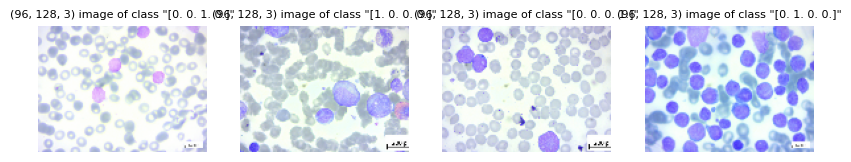

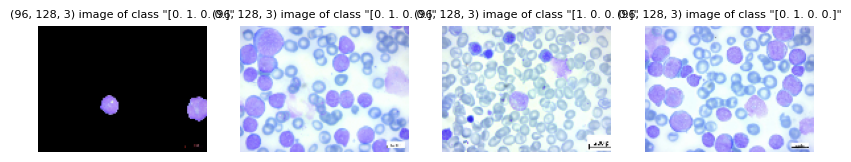

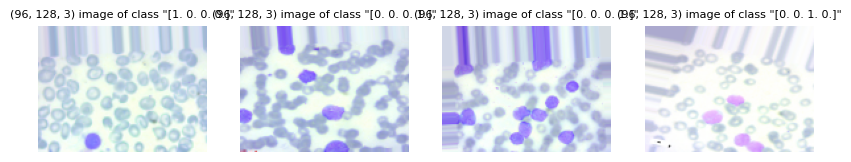

In [ ]:
show_sample_batch(ds_train, grid_size=(1,4))
show_sample_batch(ds_train_prep_1, grid_size=(1,4))
show_sample_batch(ds_train_prep_2, grid_size=(1,4))

## 5. Base model - Preprocessing Evaluation

To test the preprocessing, we used out base model, training it for 10 epochs.

The performance metrics used to evaluate the model include loss, accuracy, AUROC (Area Under the Receiver Operating Characteristic curve), recall, and precision for both training and validation sets.

### 5.1 Model Evaluation Function

In [ ]:
def modeleval(name, model=None, hyperparameters=None, ds_train=None, ds_val=None, input_shape=None, train=True, verbose=1, 
              printPlot=False, class_weight_dict=None):
    
    global model_log
    model_log = []

    if model is not None:
        # Builds the DAG 
        model.build(input_shape)

        # Check the network
        model.summary()

        if train:
            # Measure the start time
            start = time.time()

            learning_rate = hyperparameters["learning_rate"]

            # Choose the optimizer based on the condition
            optimizer = optimizers.Adam(learning_rate=learning_rate) if hyperparameters["optimizer"] == "adam" else optimizers.SGD(learning_rate=learning_rate)

            # Compile the model with the chosen optimizer
            model.compile(loss=losses.CategoricalCrossentropy(),
                          optimizer=optimizer,
                          metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                                   metrics.AUC(name='AUROC', multi_label=True),
                                   metrics.Recall(name='recall', class_id=0),
                                   metrics.Precision(name='precision')])

            epochs = hyperparameters["epochs"]

            # Add the EarlyStopping callback if early_stopping_patience is defined
            callbacks = []
            if hyperparameters["early_stopping_patience"] is not None:
                early_stopping = EarlyStopping(monitor='val_loss', patience=hyperparameters["early_stopping_patience"], restore_best_weights=True)
                callbacks.append(early_stopping)

            # Pass the class_weight_dict parameter to the fit method if provided
            history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=verbose, callbacks=callbacks, class_weight=class_weight_dict if class_weight_dict is not None else None)

            # Measure the end time
            print("Training time: {:.4f}s".format(time.time() - start))

        if printPlot:
            df_hist = pd.DataFrame.from_dict(history.history)
            df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
            secondary_y = ["accuracy", "val_accuracy"]
            ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                              secondary_y=secondary_y,
                              kind="line", figsize=(6, 3), grid=True, legend=True,
                              ylabel="Categorical cross-entropy",
                              xlabel="Epoch", title="Learning curves",
                              style=[".--", ".-"] * 3,
                              color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"],
                              alpha=0.75, fontsize=10)
            ax.right_ax.set_ylabel("Accuracy")
            ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
            ax.right_ax.set_ylim(0.45, 1.05)
            ax.legend(loc=(1.15, 0.40), framealpha=1.0)
            plt.show()

        model_log.append([name, hyperparameters, history])

    return model

### 5.2 Base Model - CNN4

In [ ]:
#base model

class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x

class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # # Z-scores 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=dicParams['seed'])        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=dicParams['seed'])   
        # etc.
        # Classifier
        self.dense4 = layers.Dense(units=4, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense4(x)
        return x


# Create an instance of CustomCNN
cnn4 = CustomResNet(seed=dicParams['seed'])

### 5.3 Preprocessing Perfomance Evaluation

#### 5.3.1 Train Original

Model: "custom_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  multiple                 12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization_1 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 bottleneck_block (Bottlenec  multiple                 58752     
 kBlock)                                                         
                                                                 
 bottleneck_block_1 (Bottlen  multiple                 96384     
 eckBlock)                                          

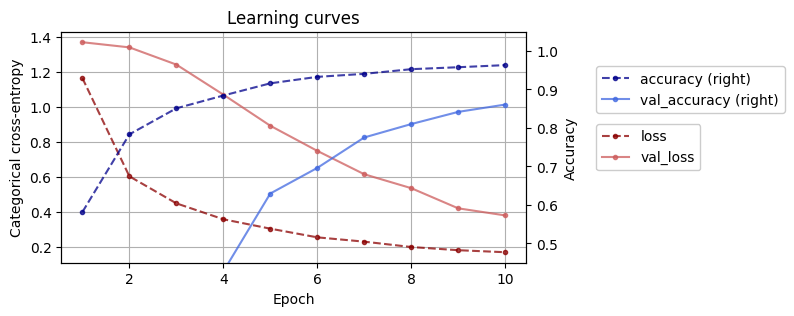

In [ ]:
customcnn1 = modeleval('base model', model=cnn4, hyperparameters=dicModelParams, ds_train=ds_train, ds_val=ds_val, input_shape=input_shape, class_weight_dict=None, printPlot=True)

#### 5.3.2 Preprocessed Training dataset - Option 1

Black background and kmeans filling with balanced dataset created by augmentation

Model: "custom_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  multiple                 12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization_1 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 bottleneck_block (Bottlenec  multiple                 58752     
 kBlock)                                                         
                                                                 
 bottleneck_block_1 (Bottlen  multiple                 96384     
 eckBlock)                                          

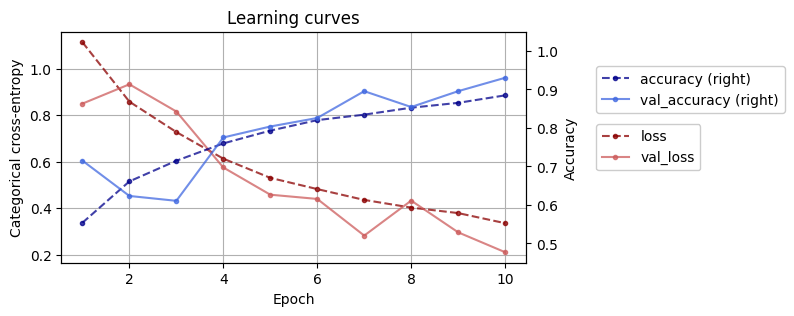

In [ ]:
customcnn1 = modeleval('base model', model=cnn4, hyperparameters=dicModelParams, ds_train=ds_train_prep_1, ds_val=ds_val, input_shape=input_shape_prep_1, class_weight_dict=None, printPlot=True)

#### 5.3.2 Preprocessed Training dataset - Option 2

Augmentation generated by ImageDataGenerator and weight for balancing classes

Model: "custom_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  multiple                 12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization_1 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 bottleneck_block (Bottlenec  multiple                 58752     
 kBlock)                                                         
                                                                 
 bottleneck_block_1 (Bottlen  multiple                 96384     
 eckBlock)                                          

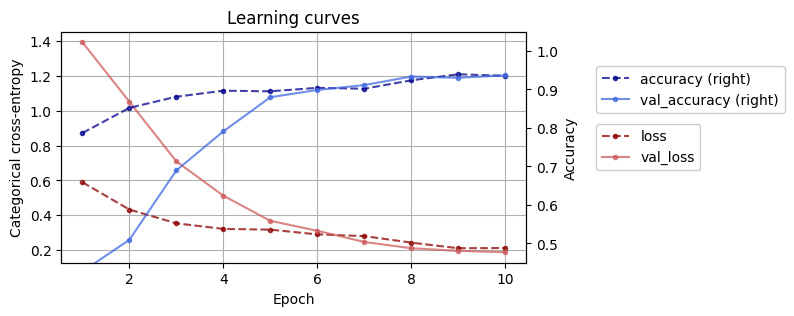

In [ ]:
customcnn1 = modeleval('base model', model=cnn4, hyperparameters=dicModelParams, ds_train=ds_train_prep_2, ds_val=ds_val, input_shape=input_shape_prep_2, class_weight_dict=class_weight_dict_prep_2, printPlot=True)

## 6. Preprocessing Definition

By comparing the original dataset to the two previously defined preprocessing options, we established that, when running 10 epochs, the model with the second option of preprocessing performs better on the base model in terms of validation accuracy, recall and precision. So, we chose the second approach for preprocessing (original images + class weights + image data augmentation, but without black images).

In cancer diagnosis, the recall metric is important because it represents the proportion of true positive cases (people with cancer) that the model correctly identifies. This is crucial, as missing a cancer diagnosis (false negatives) can have severe consequences for the patient. In the case of precision, an incorrect result could lead to a healthy person being subjected to further testing, which is not ideal, but still less impactful than failing to signal a cancer-suffering patient.
